### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    
import matplotlib.colors as mcolors
import networkx as nx

### Load the dataset

In [ ]:
def import_facebook_data(path):   
    data = np.loadtxt(path,dtype=int)
    data = np.array([ [u,v] for u,v in data])
    data = np.unique(data,axis=0)
    return data

### Utility Functions

In [ ]:
def get_nodes(nodes_connectivity_list):
    nodes = []
    for row in nodes_connectivity_list:
        nodes.append(row[0])
        nodes.append(row[1])
    nodes = np.unique(nodes)
    return sorted(nodes)

def get_nodes_mapping(nodes):
    #Create a mapping from (node) -> (index), where index in range(0,num_nodes)
    node_to_idx = {}
    idx_to_node = {}
    for i,node in enumerate(nodes):
        node_to_idx[node]= i
        idx_to_node[i]=node
    return node_to_idx,idx_to_node

def get_adj_matrix(nodes_connectivity_list,node_to_idx,num_nodes):
    adj_matrix = np.zeros((num_nodes,num_nodes),dtype=int)
    for row in nodes_connectivity_list:
        node_1 = node_to_idx[row[0]] 
        node_2 = node_to_idx[row[1]]
        adj_matrix[node_1][node_2] = 1
        adj_matrix[node_2][node_1] = 1
    return adj_matrix

### Spectral Decomposition : Single Iteration

In [ ]:
def spectralDecomp_OneIter(nodes_connectivity_list):
    nodes = get_nodes(nodes_connectivity_list)
    num_nodes = len(nodes)

    #Create a mapping from (node) -> (index), where index in range(0,num_nodes)
    node_to_idx, idx_to_node = get_nodes_mapping(nodes)
    
    #Create Adjacency Matrix
    adj_matrix = get_adj_matrix(nodes_connectivity_list,node_to_idx,num_nodes)
                
    #Create Degree Matrix
    degree_matrix = np.zeros((num_nodes,num_nodes),dtype=int)
    for node,row in enumerate(adj_matrix):
        degree_matrix[node][node] = np.sum(row) 
    
    #Create Laplacian Matrix
    laplacian_matrix = degree_matrix - adj_matrix

    #Get eigen vectors of laplcain_matrix
    eig_vals, eig_vecs = np.linalg.eig(laplacian_matrix)
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)
    idx = np.argsort(eig_vals)
    fielder_vec = eig_vecs[:,idx[1]]

    #Let c1_min_node -> min node id for cluster 1 
    c2_min_node= c1_min_node = num_nodes+1
    graph_partition_fb=np.empty((num_nodes,2),dtype=int)
    for idx,val in enumerate(fielder_vec):
        node = idx_to_node[idx]
        if val<0:
            c1_min_node = min(c1_min_node,node)
        else:
            c2_min_node = min(c2_min_node,node)
        graph_partition_fb[idx] = [node, 0 if val<0 else 1]
    
    #Assigning the community_id as the min_node_id for each node in given community
    for idx,row in enumerate(graph_partition_fb):
        label = row[1]
        if label==0:
            graph_partition_fb[idx][1] = c1_min_node
        else:
            graph_partition_fb[idx][1] = c2_min_node

    return fielder_vec,adj_matrix,graph_partition_fb

### Spectral Decomposition

In [ ]:
def spectralDecomposition(nodes_connectivity_list):
    print('Running Spectral Clustering')
    nodes = get_nodes(nodes_connectivity_list)
    num_nodes = len(nodes)

    node_to_idx, idx_to_node = get_nodes_mapping(nodes)

    queue = []
    final_clusters = np.empty((num_nodes,2),dtype=int)
    iter = 0
    unique_clusters = 0
    min_cluster_size = 20
    queue.append(nodes_connectivity_list)
    while queue:
        subgraph = queue.pop(0)
        fielder_vec_fb,adj_matrix_fb, graph_partition_fb = spectralDecomp_OneIter(subgraph)
        communities = [label for _,label in graph_partition_fb]
        community_ids = np.unique(communities)

        if(len(community_ids)==1):
            continue
        nodes_per_cluster=[]
        for community in community_ids:
            nodes_per_cluster.append(np.sum([1 if label == community else 0 for _,label in graph_partition_fb]))
        c1,c2 = nodes_per_cluster
        # Assume c1 to be the smaller cluster
        if c1>c2:
            c1,c2 = c2,c1            

        if c1< min_cluster_size :
            if c1/c2 < 0.1:
                continue

        print(f'IDs of the Communities Found: {community_ids}')
        for node,label in graph_partition_fb:
            idx = node_to_idx[node]
            final_clusters[idx][0] = node
            final_clusters[idx][1] = label

        for i,community in enumerate(community_ids):
            if(nodes_per_cluster[i]<min_cluster_size):
                continue
            subgraph_edges = []
            for row in nodes_connectivity_list:
                u=row[0]
                v=row[1]
                if(final_clusters[node_to_idx[u]][1]==community and final_clusters[node_to_idx[v]][1]==community):
                    subgraph_edges.append([u,v])
            subgraph_nodes = get_nodes(subgraph_edges)
            if len(subgraph_nodes)>min_cluster_size:
                queue.append(subgraph_edges)

        unique_clusters = len(np.unique([label for _,label in final_clusters]))
        print(f'Clusters Formed Until Now: {unique_clusters}')
        iter+=1
    return final_clusters

### Creating Sorted Ajacency Matrix

In [ ]:
def createSortedAdjMat(partition, edge_list):
        # Get the unique node names from the edge list
        nodes = np.unique(edge_list)
        name_to_index = {}
        index_to_name = {}
        for index, name in enumerate(nodes):
            name_to_index[name] = index
            index_to_name[index] = name
            
        # Get the number of nodes in the network
        num_nodes = len(nodes)

        # Create an empty matrix of zeros with the size of num_nodes by num_nodes
        adjacency_matrix = np.zeros((num_nodes,num_nodes),dtype=int)
        # Loop over the edge list and assign 1 to the matrix elements that correspond to the edges
        for edge in edge_list:
            u = edge[0] 
            v = edge[1] 
            u_index = name_to_index[u]
            v_index = name_to_index[v]
            adjacency_matrix[u_index][v_index] = 1
            adjacency_matrix[v_index][u_index] = 1
        
        # Sort the partition list by the cluster representatives
        sorted_partition = partition[partition[:, 1].argsort()]
        # Get the indices of the nodes in the sorted order
        sorted_indices = [name_to_index[i] for i in sorted_partition[:,0]]
        
        # Sort the adjacency matrix by the sorted indices
        sorted_adjacency_matrix = adjacency_matrix[sorted_indices][:,sorted_indices]
        
        return sorted_adjacency_matrix

### Plotting Functions

In [40]:
def plot_sorted_adjMatrix(sorted_adj_matrix,plot_title):
    print('Plotting Sorted Adjacency Matrix:')
    plt.imshow(sorted_adj_matrix,cmap='inferno_r')
    plt.title(plot_title)
    plt.show()
    plt.savefig('../plots/spectral_adj_matrix.png')

def plot_fiedler_vec(fielder_vec_fb):
    print('Plotting Fiedler Vector')
    fielder_vec_fb = np.sort(fielder_vec_fb)
    plt.plot(fielder_vec_fb)
    plt.grid(True)
    plt.xlabel('Dimension')
    plt.ylabel('Eigen Vector Values per dimension')
    plt.title('Fiedler Vector')
    plt.savefig('../plots/fiedler_vector.png')


def plot_graph(graph_partition,edges):
    print('Visualizing Communities')
    nodes = []
    communities = []
    for node,label in graph_partition:
        nodes.append(node)
        communities.append(label)
    n_communities = len(np.unique(communities))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_communities))
    cmap = mcolors.ListedColormap(colors)

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    print(f'No of Nodes: {G.number_of_nodes()} | No of Edges: {G.number_of_edges()}')
    nx.draw(G, with_labels=False,node_color=communities,cmap=cmap)
    plt.show()
    plt.savefig("../plots/community_graph.png")

In [ ]:
#Loading Dataset
nodes_connectivity_list_fb = import_facebook_data("../data/facebook_combined.txt")

Single Iteration of Spectral Clustering Completed
Plotting Sorted Adjacency Matrix:


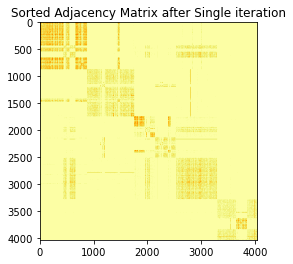

<Figure size 432x288 with 0 Axes>

In [30]:
#Running for single iteration & plotting sorted adj matrix, fiedler Vector
fielder_vec_fb, adj_mat_fb, graph_partition_fb = spectralDecomp_OneIter(nodes_connectivity_list_fb)
print('Single Iteration of Spectral Clustering Completed')


sorted_adj_matrix = createSortedAdjMat(graph_partition_fb,nodes_connectivity_list_fb)
plot_sorted_adjMatrix(sorted_adj_matrix,plot_title='Sorted Adjacency Matrix after Single iteration')


Plotting Fiedler Vector


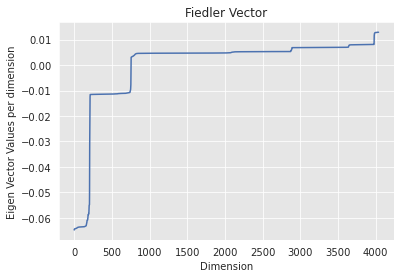

In [45]:
#Plotting Fielder Vector
plot_fiedler_vec(fielder_vec_fb)

Running Spectral Clustering
IDs of the Communities Found: [  0 686]
Clusters Formed Until Now: 2
IDs of the Communities Found: [  0 594]
Clusters Formed Until Now: 3
IDs of the Communities Found: [686 755]
Clusters Formed Until Now: 4
IDs of the Communities Found: [  0 107]
Clusters Formed Until Now: 5
IDs of the Communities Found: [  0 136]
Clusters Formed Until Now: 6
IDs of the Communities Found: [107 990]
Clusters Formed Until Now: 7
IDs of the Communities Found: [0 1]
Clusters Formed Until Now: 8
IDs of the Communities Found: [107 348]
Clusters Formed Until Now: 9
IDs of the Communities Found: [ 0 15]
Clusters Formed Until Now: 10
IDs of the Communities Found: [1 2]
Clusters Formed Until Now: 11
IDs of the Communities Found: [348 369]
Clusters Formed Until Now: 12
IDs of the Communities Found: [2 8]
Clusters Formed Until Now: 13
IDs of the Communities Found: [ 2 49]
Clusters Formed Until Now: 14
IDs of the Communities Found: [ 8 39]
Clusters Formed Until Now: 15
IDs of the Communi

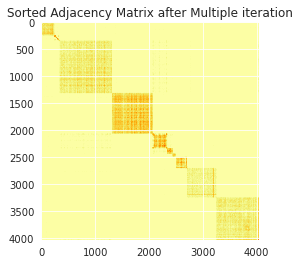

<Figure size 432x288 with 0 Axes>

In [46]:
#Running for multiple iterations & plotting
graph_partition_fb = spectralDecomposition(nodes_connectivity_list_fb)

print('Plotting Sorted Adjacency Matrix Now:')
sorted_adj_matrix = createSortedAdjMat(graph_partition_fb,nodes_connectivity_list_fb)
plot_sorted_adjMatrix(sorted_adj_matrix,plot_title='Sorted Adjacency Matrix after Multiple iteration')


Visualizing Communities
4039 88234


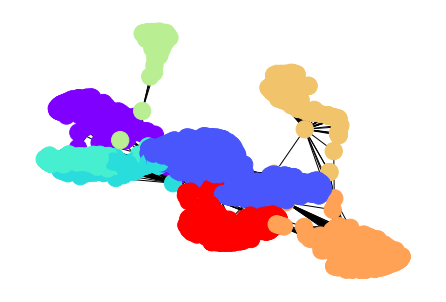

<Figure size 432x288 with 0 Axes>

In [47]:
#Plotting graph to visualize communities
plot_graph(graph_partition_fb,nodes_connectivity_list_fb)